In [17]:
import gymnasium as gym
import ale_py
import numpy as np

# Custom wrapper to give -1 reward on life loss
class NegativeLifeRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.lives = 0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # ALE keeps track of lives
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Check current lives
        current_lives = self.env.unwrapped.ale.lives()
        # If a life is lost, give negative reward
        if current_lives < self.lives:
            reward -= 1.0  # penalty for losing a life
            self.lives = current_lives

        return obs, reward, terminated, truncated, info


# Usage
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="human")
env = NegativeLifeRewardWrapper(env)

observation, info = env.reset()
episode_over = False

while not episode_over:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if reward != 0.0:
        print("reward", reward)
    episode_over = terminated or truncated

env.close()


reward -1.0
reward -1.0
reward -1.0
reward -1.0
reward -1.0


(84, 84)


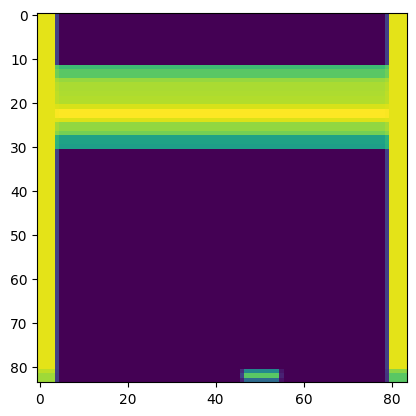

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess_image(frame,new_size=(84, 84)):
        """
        Takes an Atari Breakout RGB frame (210x160x3)
        Returns a cropped, grayscale, resized frame (H, W)
        """
        # 1. Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # 2. Crop the game area (remove top score + borders)
        # Breakout: useful area is row 34 to 194
        cropped = gray[34:194, :]   # shape: (160,160)

        # 3. Resize to new_size
        resized = cv2.resize(cropped, new_size, interpolation=cv2.INTER_AREA)

        # 4. Normalize (optional)
        normalized = resized.astype(np.float32) / 255.0

        return normalized


image = preprocess_image(observation)
print(image.shape)
plt.imshow(image)

In [19]:
import torch
import torch.nn as nn

ENV_NAME = "ALE/Breakout-v5"
LEARNING_RATE = 1e-3
EPISODES = 50000
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.00
EPSILON_DECAY = 0.99
BATCH_SIZE = 3000
MEMORY_SIZE = 1000000
TARGET_UPDATE = 10
epsilon = EPSILON_START

# Neural Network for Q-Learning
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class DQN(nn.Module):
    def __init__(self, input_channels, action_dim):
        """
        input_channels: number of stacked frames (usually 4)
        action_dim: number of actions in Breakout (4 for Gym)
        """
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),   # (4, 84, 84) -> (32, 20, 20)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2),               # (32, 20, 20) -> (64, 9, 9)
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1),               # (64, 9, 9) -> (64, 7, 7)
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim)
        )

    def forward(self, x):
        """
        x: shape (batch, 4, 84, 84)
        """
        x = x.to(device)        # ensure input is on same device
        x = self.conv(x)
        x = x.view(x.size(0), -1)   # flatten
        return self.fc(x)

Using device: cuda


In [20]:
model = DQN(4,env.env.action_space.n).to(device)

input = torch.randn((1,4,84,84))

out = model(input)

env.action_space

Discrete(4)

In [21]:
from collections import deque , namedtuple
import random
import torch.optim as optim
import numpy as np



In [22]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))

#the replayMemory Class
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
def select_action(policy_net,state):
    if random.random()<epsilon:
         action = env.action_space.sample()
         return action
    else:
        with torch.no_grad():

            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            return policy_net(state).argmax(dim=1).item()

def train_dqn(policy_net,target_net,memory,optimizer):
    if memory.__len__()<BATCH_SIZE:
        return
    sample = memory.sample(BATCH_SIZE)


    batch = Transition(*zip(*sample))

    # Convert all batch elements to single NumPy arrays first
    states = torch.tensor(np.array(batch.state), dtype=torch.float32).to(device)
    actions = torch.tensor(np.array(batch.action), dtype=torch.int64).unsqueeze(1).to(device)
    next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32).to(device)
    rewards = torch.tensor(np.array(batch.reward), dtype=torch.float32).to(device)
    dones = torch.tensor(np.array(batch.done), dtype=torch.float32).to(device)


    current_q_values = policy_net(states).gather(1,actions)

    next_q_values =  target_net(next_states).max(1)[0].detach()
    target_q_values = rewards +(GAMMA * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# LEARNING_RATE = 0.0001
# EPISODES = 200

gym.register_envs(ale_py)
env = gym.make(ENV_NAME)
env = NegativeLifeRewardWrapper(env)

state_dim = 4
action_dim = env.action_space.n
trained_model = DQN(state_dim, action_dim)
# trained_model.load_state_dict(torch.load("breakout.pth"))

policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)

target_net.load_state_dict(trained_model.state_dict())
policy_net.load_state_dict(trained_model.state_dict())

target_net.train()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)

rewards = []
stacked_current_frames =  deque(maxlen=4)
stacked_next_frames =  deque(maxlen=4)

frame_skipping = 4
best_reward = -float("inf")
save_model = False
for episode in range(EPISODES):

    stacked_current_frames.clear()
    stacked_next_frames.clear()

    state = env.reset()[0]
    episode_reward = 0
    last_frame = np.zeros((84,84))
    state = preprocess_image(state)
    current_frame = state
    t=0
    while True:

        t+=1
        stacked_current_frames.append(state)

        if t %4 == 0 or t == 0:
            if len(stacked_current_frames)==4:
                action = select_action( policy_net,stacked_current_frames)
                if len(memory) >BATCH_SIZE:
                    save_model=True
            else:
                action= env.action_space.sample()

        current_frame  = np.maximum(current_frame,last_frame)

        next_state, reward, done, truncated, __= env.step(action)
        next_state = preprocess_image(next_state)

        stacked_next_frames = stacked_current_frames.copy()
        stacked_next_frames.append(next_state)

        if len(stacked_current_frames)==4 and len(stacked_next_frames)==4:

            current_states = np.stack(list(stacked_current_frames))
            next_states = np.stack(list(stacked_next_frames))

            memory.push(current_states, action, next_states, reward, done)

        current_frame = next_state
        last_frame = state

        state = next_state
        episode_reward += reward

        train_dqn(policy_net, target_net, memory, optimizer)

        if t%50==0  and t!=0:
            print("reward: ",episode_reward,f"epsilon {epsilon:.2f}")

        if done or truncated:
            break


    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode_reward > best_reward and save_model is True:
        best_reward = episode_reward
        # Save the trained model
        print("Saving model...")
        print("best rewards",best_reward)
        torch.save(policy_net.state_dict(), "breakout.pth")

    rewards.append(episode_reward)
    print(f"Episode {episode+1}, Reward: {episode_reward}, Epsilon: {epsilon:.2f}")



# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('DQN Training on CartPole')
plt.show()

reward:  -1.0 epsilon 0.78
reward:  -2.0 epsilon 0.78
reward:  -3.0 epsilon 0.78
reward:  -3.0 epsilon 0.78
Episode 1, Reward: -4.0, Epsilon: 0.77
reward:  1.0 epsilon 0.77
reward:  -1.0 epsilon 0.77
reward:  -2.0 epsilon 0.77
reward:  -3.0 epsilon 0.77
Episode 2, Reward: -3.0, Epsilon: 0.76
reward:  -1.0 epsilon 0.76
reward:  -1.0 epsilon 0.76
reward:  0.0 epsilon 0.76
reward:  -1.0 epsilon 0.76
reward:  -1.0 epsilon 0.76
reward:  -1.0 epsilon 0.76
Episode 3, Reward: -2.0, Epsilon: 0.75
reward:  0.0 epsilon 0.75
reward:  0.0 epsilon 0.75
reward:  1.0 epsilon 0.75
reward:  1.0 epsilon 0.75
reward:  0.0 epsilon 0.75
reward:  -1.0 epsilon 0.75
reward:  0.0 epsilon 0.75
Episode 4, Reward: -1.0, Epsilon: 0.75
reward:  0.0 epsilon 0.75
reward:  -2.0 epsilon 0.75
reward:  -4.0 epsilon 0.75
reward:  -3.0 epsilon 0.75
Episode 5, Reward: -4.0, Epsilon: 0.74
reward:  -1.0 epsilon 0.74
reward:  -2.0 epsilon 0.74
reward:  -2.0 epsilon 0.74
reward:  -2.0 epsilon 0.74
Episode 6, Reward: -3.0, Epsilo

In [ ]:
len(memory) >BATCH_SIZE